<a href="https://colab.research.google.com/github/jems2019/MastersProjectWebApp/blob/master/Stock_Market_Prediction_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock price prediction using LSTM

Reference https://medium.com/insea-it-blog/stock-price-prediction-using-lstm-97f0fff454b

(5086, 6)


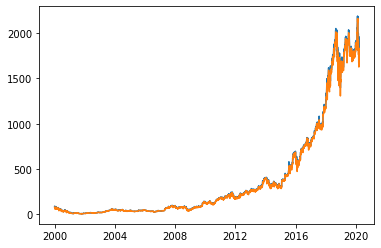

In [15]:
data = DataReader('AMZN', 'yahoo', '2000-01-01')

print(data.shape)
plt.plot(data['High'])
plt.plot(data['Low'])
plt.show()

In [16]:
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,89.5625,79.046875,81.5000,89.3750,16117600,89.3750
2000-01-04,91.5000,81.750000,85.3750,81.9375,17487400,81.9375
2000-01-05,75.1250,68.000000,70.5000,69.7500,38457400,69.7500
2000-01-06,72.6875,64.000000,71.3125,65.5625,18752000,65.5625
2000-01-07,70.5000,66.187500,67.0000,69.5625,10505400,69.5625


In [0]:
data['Close'] = pd.to_numeric(data.Close,errors='coerce') 
data = data.dropna() 
trainData = data.iloc[:,3:4].values 
sc = MinMaxScaler(feature_range=(0,1)) # scaling data
trainData = sc.fit_transform(trainData)

X_train = []
y_train = []
for i in range (60,1149): 
    X_train.append(trainData[i-60:i,0]) 
    y_train.append(trainData[i,0])
X_train,y_train = np.array(X_train),np.array(y_train)
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)) 

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [19]:
model = Sequential()
model.add(LSTM(units=100, return_sequences = True,
               input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(units =1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 20, batch_size = 32, verbose=1)

Train on 816 samples, validate on 273 samples
Epoch 1/20
816/816 [==============================] - 11s 13ms/step - loss: 8.1225e-05 - val_loss: 5.0759e-05
Epoch 2/20
816/816 [==============================] - 8s 9ms/step - loss: 4.1545e-05 - val_loss: 3.0240e-05
Epoch 3/20
816/816 [==============================] - 7s 9ms/step - loss: 9.6528e-06 - val_loss: 6.1006e-06
Epoch 4/20
816/816 [==============================] - 7s 9ms/step - loss: 5.2503e-06 - val_loss: 3.4220e-06
Epoch 5/20
816/816 [==============================] - 8s 9ms/step - loss: 5.4836e-06 - val_loss: 4.8863e-06
Epoch 6/20
816/816 [==============================] - 8s 9ms/step - loss: 6.5124e-06 - val_loss: 9.0952e-06
Epoch 7/20
816/816 [==============================] - 8s 9ms/step - loss: 5.8525e-06 - val_loss: 3.3103e-06
Epoch 8/20
816/816 [==============================] - 8s 9ms/step - loss: 5.7932e-06 - val_loss: 2.9824e-06
Epoch 9/20
816/816 [==============================] - 8s 9ms/step - loss: 4.4426e-06 - v

In [0]:
# Testing the model 
testData = DataReader('GOOG', 'yahoo', '2000-01-01')
testData['Close'] = pd.to_numeric(testData.Close, errors='coerce')
testData = testData.dropna() 
testData = testData.iloc[:,3:4] 
y_test = testData.iloc[60:,0:].values 
inputClosing = testData.iloc[:,0:].values
inputClosing_scaled = sc.transform(inputClosing)

X_test = []
length = len(testData)
timestep = 60
for i in range(timestep,length): 
    X_test.append(inputClosing_scaled[i-timestep:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
y_pred = model.predict(X_test)
predicted_price = sc.inverse_transform(y_pred)

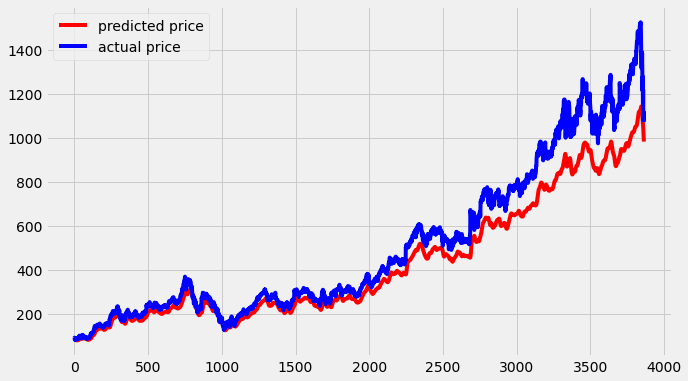

In [78]:
plt.plot(predicted_price, "-r", label ='predicted price')
plt.plot(testData.Close.values[60:], "-b", label ='actual price')
plt.legend(loc="upper left")
plt.show()

In [96]:
# report performance
rmse = math.sqrt(mean_squared_error(testData.Close.values[60:,], predicted_price))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(predicted_price - testData.Close.values[60:,])/np.abs(testData.Close.values[60:,]))
print('MAPE: '+str(mape))

RMSE: 114.42077456880841
MAPE: 0.8844875290124273


# Time Series Forecasting
https://towardsdatascience.com/stock-market-forecasting-using-time-series-c3d21f2dd37f


In [54]:
!pip install pmdarima


     |████████████████████████████████| 1.5MB 2.7MB/s 


(5031, 6)


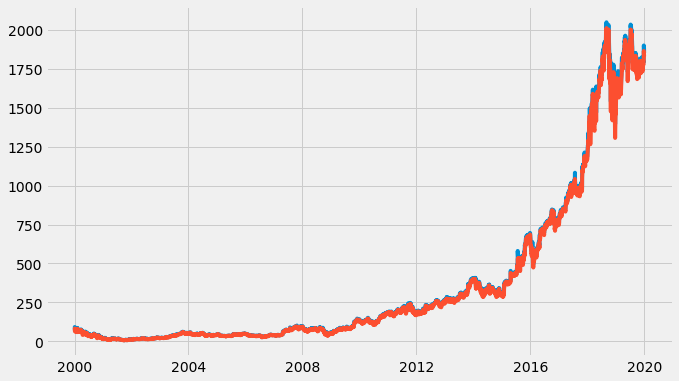

In [55]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas_datareader.data import DataReader
import math
import numpy as np

data = DataReader('AMZN', 'yahoo', '2000-01-01', '2020-01-01')

print(data.shape)
plt.plot(data['High'])
plt.plot(data['Low'])
plt.show()

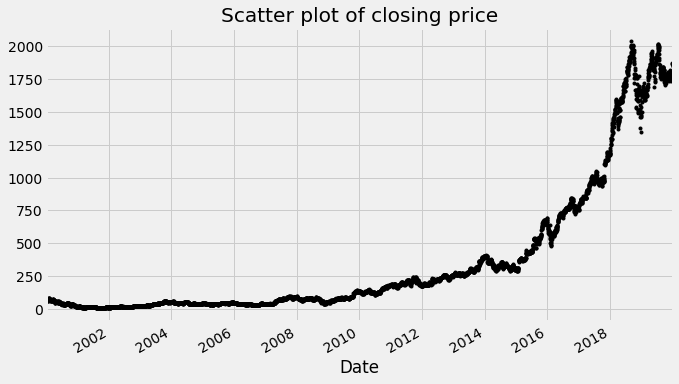

In [56]:
df_close = data['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

In [47]:
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,89.562500,79.046875,81.500000,89.375000,16117600,89.375000
2000-01-04,91.500000,81.750000,85.375000,81.937500,17487400,81.937500
2000-01-05,75.125000,68.000000,70.500000,69.750000,38457400,69.750000
2000-01-06,72.687500,64.000000,71.312500,65.562500,18752000,65.562500
2000-01-07,70.500000,66.187500,67.000000,69.562500,10505400,69.562500
...,...,...,...,...,...,...
2020-03-16,1759.449951,1626.030029,1641.510010,1689.150024,8917300,1689.150024
2020-03-17,1857.780029,1689.239990,1775.469971,1807.839966,10917100,1807.839966
2020-03-18,1841.660034,1745.000000,1750.000000,1830.000000,9645200,1830.000000


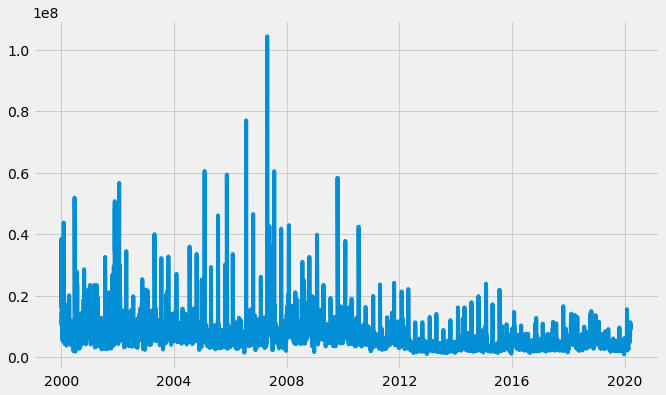

In [48]:
plt.figure()
plt.plot(data["Volume"])
plt.show()

Using the ADF (Augmented Dickey-Fuller) Test to test whether the data is stationary.

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

* Null Hypothesis: The series has a unit root (value of a =1)
* Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.
If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

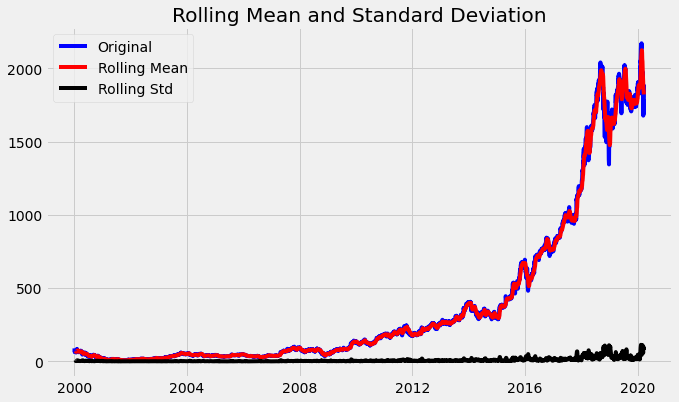

Results of dickey fuller test
Test Statistics                   1.780100
p-value                           0.998309
No. of lags used                 33.000000
Number of observations used    5052.000000
critical value (1%)              -3.431645
critical value (5%)              -2.862112
critical value (10%)             -2.567075
dtype: float64


In [49]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

The p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.
The following will separate Trend and Seasonality from the time series.

<Figure size 720x432 with 0 Axes>

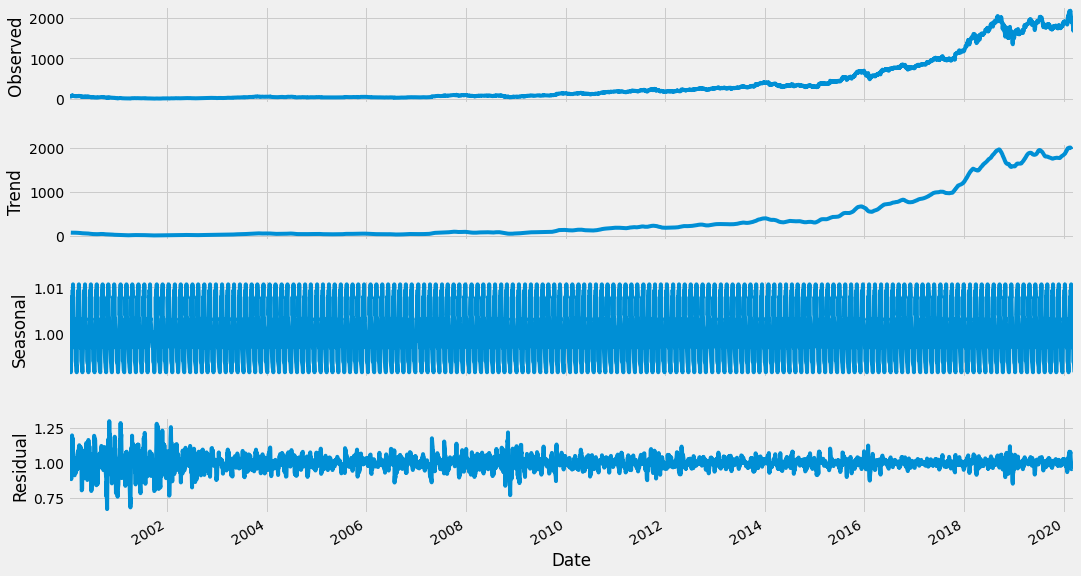

In [50]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

Start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

No handles with labels found to put in legend.


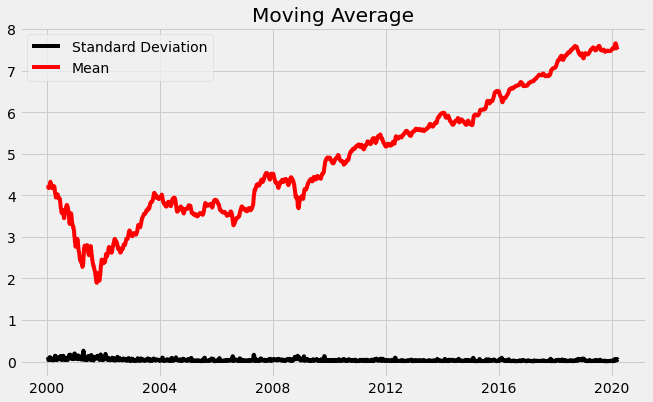

In [51]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Create an ARIMA model and train with the closing price of the stock on the train data. Splitting the training and testing set and visualize it.

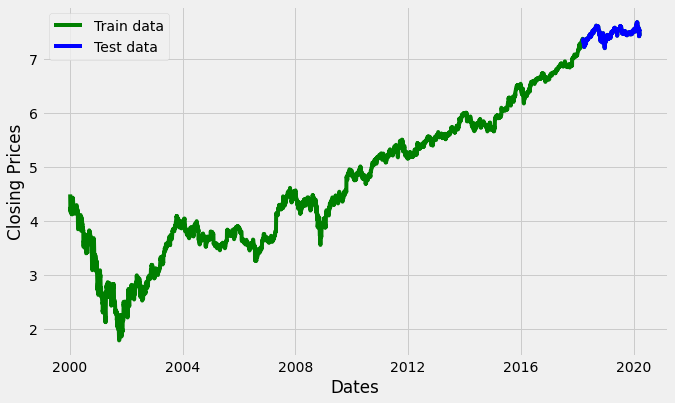

In [52]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Auto ARIMA: Automatically discover the optimal order for an ARIMA model.


The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, forecast::auto.arima.


The auro_arima function works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

In [57]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=15242.998, BIC=15255.854, Time=0.172 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-18109.384, BIC=-18090.100, Time=2.546 seconds
Near non-invertible roots for order (1, 0, 0)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=9075.481, BIC=9094.766, Time=1.450 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=27364.658, BIC=27371.086, Time=0.091 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-18105.312, BIC=-18079.600, Time=6.595 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-18105.494, BIC=-18073.354, Time=7.265 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-18026.607, BIC=-18000.894, Time=7.111 seconds
Near non-invertible roots for order (2, 0, 0)(0, 0, 0, 0); setting score to inf (at least on

So the Auto ARIMA model provided the value of p,d, and q as 3,1 and 2 respectively.

In [0]:
# review the residual plots from auto ARIMA
# model_autoARIMA.plot_diagnostics(figsize=(15,8))
# plt.show()

Standaridized residual: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Second chart shows The density plot suggest normal distribution with mean zero.

In [98]:
model = ARIMA(train_data, order=(3, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4573
Model:                 ARIMA(3, 1, 2)   Log Likelihood                9066.749
Method:                       css-mle   S.D. of innovations              0.033
Date:                Mon, 23 Mar 2020   AIC                         -18119.498
Time:                        04:38:15   BIC                         -18074.502
Sample:                             1   HQIC                        -18103.656
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.000      1.624      0.104      -0.000       0.002
ar.L1.D.Close     0.7936      0.293      2.710      0.007       0.220       1.368
ar.L2.D.Close     0.0521      0.252     

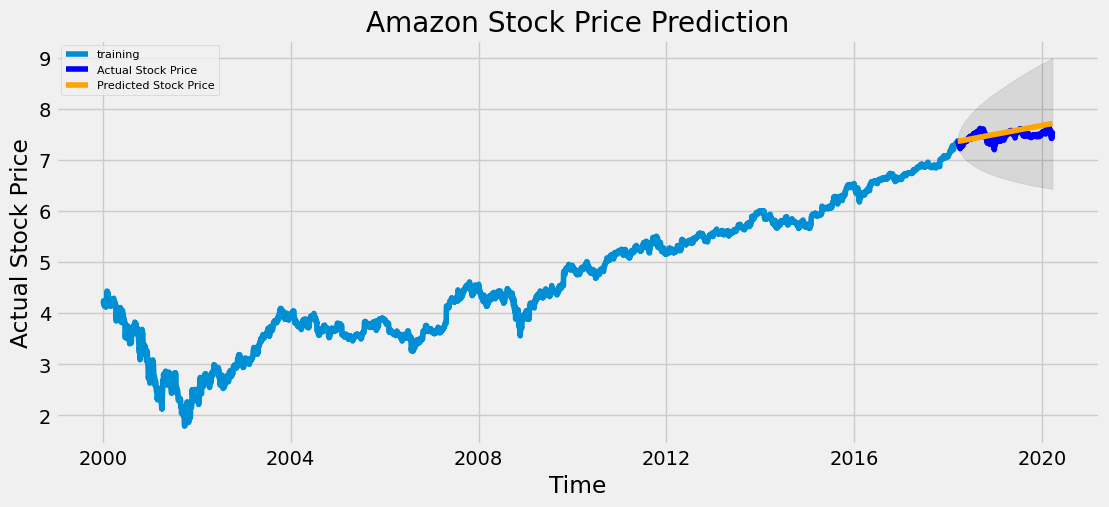

In [62]:
# Forecast
fc, se, conf = fitted.forecast(509, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Amazon Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [63]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.013350809889566901
MAE: 0.09757007645351413
RMSE: 0.11554570476468133
MAPE: 0.013069686385127895


Around 1.3% MAPE(Mean Absolute Percentage Error) implies the model is about 98.7% accurate in predicting the test set observations.

# Notes


In [0]:
# Reference https://towardsdatascience.com/getting-rich-quick-with-machine-learning-and-stock-market-predictions-696802da94fe
# https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944
# https://medium.com/insea-it-blog/stock-price-prediction-using-lstm-97f0fff454b

(5086, 6)


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


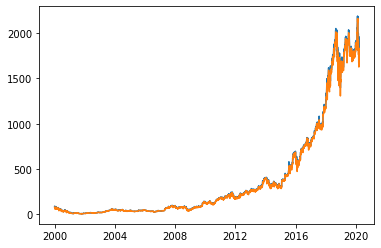

In [1]:
import numpy as np  
import pandas as pd  
from pandas_datareader import data as wb  
import matplotlib.pyplot as plt  
from scipy.stats import norm
from datetime import timedelta
from pandas_datareader.data import DataReader
%matplotlib inline


data = DataReader('AMZN', 'yahoo', '2000-01-01')

print(data.shape)
plt.plot(data['High'])
plt.plot(data['Low'])
plt.show()

In [2]:
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,89.562500,79.046875,81.500000,89.375000,16117600,89.375000
2000-01-04,91.500000,81.750000,85.375000,81.937500,17487400,81.937500
2000-01-05,75.125000,68.000000,70.500000,69.750000,38457400,69.750000
2000-01-06,72.687500,64.000000,71.312500,65.562500,18752000,65.562500
2000-01-07,70.500000,66.187500,67.000000,69.562500,10505400,69.562500
...,...,...,...,...,...,...
2020-03-16,1759.449951,1626.030029,1641.510010,1689.150024,8917300,1689.150024
2020-03-17,1857.780029,1689.239990,1775.469971,1807.839966,10917100,1807.839966
2020-03-18,1841.660034,1745.000000,1750.000000,1830.000000,9645200,1830.000000


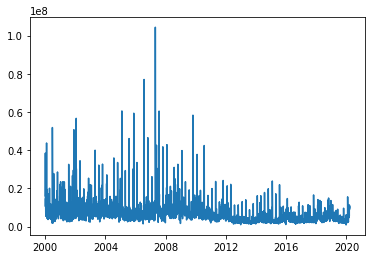

In [2]:
plt.figure()
plt.plot(data["Volume"])
plt.show()

In [3]:
print("checking if any null values are present\n", data.isna().sum())

checking if any null values are present
 High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64


In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

Train and Test size 4068 1018


In [0]:
import tqdm

def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm.tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [7]:
TIME_STEPS = 60 # looking back 2 months
BATCH_SIZE = 2

x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()



length of time-series i/o (4008, 60, 5) (4008,)



length of time-series i/o (958, 60, 5) (958,)


In [0]:
from tensorflow import keras
from keras import Sequential, optimizers
from keras.layers import *
from keras.models import *

model = Sequential()
model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform'))
model.add(Dropout(0.2))
model.add(Dense(20,activation='relu'))
model.add(Dense(1,activation='linear'))
optimizer = optimizers.RMSprop(lr=0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer)

model.summary()

In [0]:
history = model.fit(x_t, y_t, epochs=120, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)))

In [8]:
from tensorflow import keras
from keras import Sequential, optimizers
from keras.layers import *
from keras.models import *

model = Sequential()
model.add(LSTM(units=100, return_sequences = True,
               input_shape=(x_t.shape[1],5)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(units =1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.summary()




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 100)           42400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 100)           80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 100)           0         
_

In [9]:
# https://medium.com/insea-it-blog/stock-price-prediction-using-lstm-97f0fff454b
model.fit(x_t, y_t, epochs = 20, batch_size = 32, verbose=1)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





4008/4008 [==============================] - 38s 9ms/step - loss: 0.0035
Epoch 2/20
4008/4008 [==============================] - 36s 9ms/step - loss: 0.0014
Epoch 3/20
4008/4008 [==============================] - 37s 9ms/step - loss: 0.0011
Epoch 4/20
4008/4008 [==============================] - 36s 9ms/step - loss: 0.0010
Epoch 5/20
4008/4008 [==============================] - 35s 9ms/step - loss: 6.9983e-04
Epoch 6/20
4008/4008 [==============================] - 35s 9ms/step - loss: 8.2276e-04
Epoch 7/20
4008/4008 [==============================] - 36s 9ms/step - loss: 7.3568e-04
Epoch 8/20
4008/4008 [==============================] - 35s 9ms/step - loss: 7.3100e-04
Epoch 9/20
4008/4008 [==============================] - 36s 9ms/step - loss: 6.5060e-04
Epoch 10/20
4008/4008 [==============================] - 35s 9ms/step - loss: 5.4447e-04
Epoch 11/20
4008/4008 [==========

In [0]:
data['Close'] = pd.to_numeric(data.Close,errors='coerce') 
data = data.dropna() 
trainData = data.iloc[:,3:4].values 
sc = MinMaxScaler(feature_range=(0,1)) # scaling data
trainData = sc.fit_transform(trainData)

X_train = []
y_train = []
for i in range (60,1149): 
    X_train.append(trainData[i-60:i,0]) 
    y_train.append(trainData[i,0])
X_train,y_train = np.array(X_train),np.array(y_train)
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)) 

In [0]:
data['Close'] = pd.to_numeric(data.Close,errors='coerce') 
data = data.dropna() 
trainData = data.iloc[:,3:4].values 
sc = MinMaxScaler(feature_range=(0,1)) # scaling data
trainData = sc.fit_transform(trainData)

In [14]:
# Testing the model 
testData = DataReader('GOOG', 'yahoo', '2000-01-01')
testData['Close'] = pd.to_numeric(testData.Close, errors='coerce')
testData = testData.dropna() 
testData = testData.iloc[:,3:4] 
y_test = testData.iloc[60:,0:].values 
inputClosing = testData.iloc[:,0:].values
inputClosing_scaled = sc.transform(inputClosing)

X_test = []
length = len(testData)
timestep = 60
for i in range(timestep,length): 
    X_test.append(inputClosing_scaled[i-timestep:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
y_pred = model.predict(X_test)
predicted_price = sc.inverse_transform(y_pred)

ValueError: ignored

In [0]:
BATCH_SIZE = 32
history = model.fit(x_t, y_t, epochs=120, verbose=1, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)))